In [1]:
from SimPEG import *
import matplotlib.pyplot as plt
import simpegPF as PF
import matplotlib
#from get_UBC_mesh import get_UBC_mesh
from read_MAG_obs import read_MAG_obs
from get_T_mat import get_T_mat

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


SyntaxError: 'return' outside function (get_T_mat.py, line 131)

# Writing magnetostatic problem with integral formulation

## - Create tensor matrix TxTyTz

### Step:1 Generating mesh and operators

In [2]:
#mesh = Utils.meshutils.readUBCTensorMesh("Tile1.msh")
cs = 25.
hxind = [(cs,5,-1.3), (cs/2.0, 21),(cs,5,1.3)]
hyind = [(cs,5,-1.3), (cs/2.0, 21),(cs,5,1.3)]
hzind = [(cs,5,-1.3),(cs/2.0, 20)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

xn = mesh.vectorNx
yn = mesh.vectorNy
zn = mesh.vectorNz


mcell = (xn.size-1) * (yn.size-1) * (zn.size-1)

N = mesh.gridN

Utils.meshutils.writeUBCTensorMesh('Mesh.msh',mesh)


In [4]:
sph_ind = PF.MagAnalytics.spheremodel(mesh, 0, 0, 175, 50)

Utils.meshutils.writeUBCTensorModel('Mesh.dat',mesh,sph_ind)

In [5]:
# Load in obsfile
#Decl, Incl, B0, Mdec, Minc, obsx, obsy, obsz, data, unct = read_MAG_obs('Obs_RAW_REM_GRID_TMI.obs')

Incl = 90.
Decl = 00.
B0 = 50000
        
# Or create juste a plane grid
xr = np.linspace(-125, 125, 25)
yr = np.linspace(-125, 125, 25)
X, Y = np.meshgrid(xr, yr)
Z = np.ones((xr.size, yr.size))*280
rxLoc = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
     
aa = np.array([[0,0,0],[0,0,0]])

aa[1,0:3] = 1
print aa
ndata = rxLoc.shape[0]

# Write obsfile in UBC format
with file('Obs_loc.dat','w') as fid:
    fid.write('%6.2f %6.2f %6.2f\n' %(Incl, Decl, B0) )
    fid.write('%6.2f %6.2f %6.2f\n' %(Incl, Decl, 1) )  
    np.savetxt(fid, rxLoc, fmt='%-7.2f',delimiter=' ',newline='\n')


[[0 0 0]
 [1 1 1]]


In [6]:
# Create magnetization matrix
mx = np.cos(np.deg2rad(Incl)) * np.cos(np.deg2rad(Decl))
my = np.cos(np.deg2rad(Incl)) * np.sin(np.deg2rad(Decl))
mz = np.sin(np.deg2rad(Incl))

In [30]:
Mx = Utils.sdiag(np.ones([mcell])*mx*B0)
My = Utils.sdiag(np.ones([mcell])*my*B0)
Mz = Utils.sdiag(np.ones([mcell])*mz*B0)

#matplotlib.pyplot.spy(scipy.sparse.csr_matrix(Mx))
#plt.show()
M = sp.vstack((Mx,My,Mz));


In [44]:
# Call the function to build tensor matrix

Tx = empty([ndata,3*mcell], dtype=float)
Ty = empty([ndata,3*mcell], dtype=float)
Tz = empty([ndata,3*mcell], dtype=float)
    
Tx, Ty, Tz = get_T_mat(xn,yn,zn,rxLoc)

print Tx[0,0],Ty[0,0],Tz[0,0]


NameError: name 'empty' is not defined

For sparse matrix
b = A*x

For dense matrix 
b = A.dot(x)

In [16]:
x = np.ones(10)
y = np.ones(10)*3

In [19]:
x.dot(y)

30.0

In [15]:
Gx = Tx*M

In [10]:
cs = 25.
hxind = [(cs,5,-1.3), (cs/2.0, 41),(cs,5,1.3)]
hyind = [(cs,5,-1.3), (cs/2.0, 41),(cs,5,1.3)]
hzind = [(cs,5,-1.3), (cs/2.0, 40),(cs,5,1.3)]
M3 = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

### Step4: Compute analytic function (sphere in whole space)
Outside of the sphere $(r>R)$

$$\mathbf{H}_1 = H_0 \hat{x} + H_0\frac{R}{r^5}\frac{\mu_2-\mu_1}{\mu_2+2\mu_1}[(2x^2-y^2-z^2)\hat{x}+(3xy)\hat{y}+(3xz)\hat{z}]$$

$$H_{x1} = H_0 + H_0\frac{R}{r^5}\frac{\mu_2-\mu_1}{\mu_2+2\mu_1}(2x^2-y^2-z^2)$$

$$H_{y1} =  H_0\frac{R}{r^5}\frac{\mu_2-\mu_1}{\mu_2+2\mu_1}(3xy)$$

$$H_{z1} =  H_0\frac{R}{r^5}\frac{\mu_2-\mu_1}{\mu_2+2\mu_1}(3xz)$$

Inside of the sphere $(r\le R)$

$$\mathbf{H}_2 = H_0\frac{3\mu_1}{\mu_2+2\mu_1}\hat{x}$$

$$H_{x2} = H_0\frac{3\mu_1}{\mu_2+2\mu_1}$$

### Step5: Projection to receiver plane

In [19]:
rxLoc = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
Qfx = M3.getInterpolationMat(rxLoc,'Fx')
Qfy = M3.getInterpolationMat(rxLoc,'Fy')
Qfz = M3.getInterpolationMat(rxLoc,'Fz')

In [20]:
Bxr = np.reshape(Qfx*B, (size(xr), size(yr)), order='F')
Byr = np.reshape(Qfy*B, (size(xr), size(yr)), order='F')
Bzr = np.reshape(Qfz*B, (size(xr), size(yr)), order='F')
H0 = Box/mu0
flag = 'secondary'
if flag=='secondary':
    Bxr = Bxr-Box

# Bxra, Byra, Bzra = MagSphereAnalFun(X, Y, Z, 100, 0., 0., 0., mu0, mu0*(1+chiblk), H0, flag)
Bxra, Byra, Bzra = MagSphereAnalFunA(X, Y, Z, 100., 0., 0., 0., chiblk, np.array([1., 0., 0.]), flag)

Bxra = np.reshape(Bxra, (size(xr), size(yr)), order='F')
Byra = np.reshape(Byra, (size(xr), size(yr)), order='F')
Bzra = np.reshape(Bzra, (size(xr), size(yr)), order='F')

100.0 kang


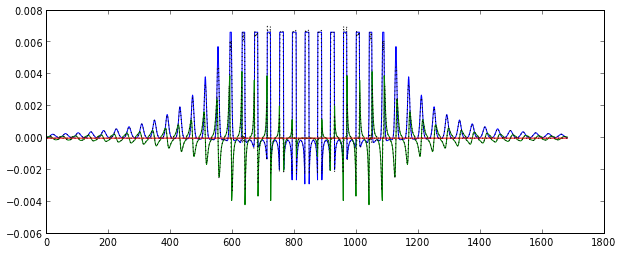

In [22]:
figsize(10, 4)
plot(Utils.mkvc(Bxra))
plot(Utils.mkvc(Bxr), 'k:')
plot(Utils.mkvc(Byra))
plot(Utils.mkvc(Byr), 'k:')
plot(Utils.mkvc(Bzra))
plot(Utils.mkvc(Bzr), 'k:')

<matplotlib.colorbar.Colorbar instance at 0x000000001244C608>

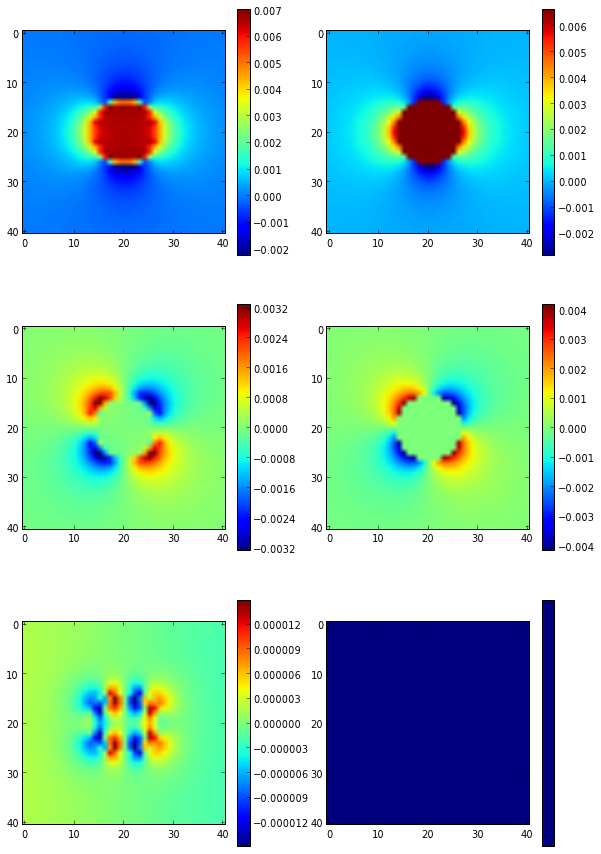

In [24]:
fig, ax = subplots(3,2, figsize = (10,15))
dat1 = ax[0,0].imshow(Bxr); fig.colorbar(dat1, ax=ax[0,0])
dat2 = ax[0,1].imshow(Bxra); fig.colorbar(dat2, ax=ax[0,1])
dat3 = ax[1,0].imshow(Byr); fig.colorbar(dat3, ax=ax[1,0])
dat4 = ax[1,1].imshow(Byra); fig.colorbar(dat4, ax=ax[1,1])
dat5 = ax[2,0].imshow(Bzr); fig.colorbar(dat5, ax=ax[2,0])
dat6 = ax[2,1].imshow(Bzra); fig.colorbar(dat6, ax=ax[2,1])

[-285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285.
 -285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285.
 -285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285. -285.
 -285. -285. -285. -285. -285.]


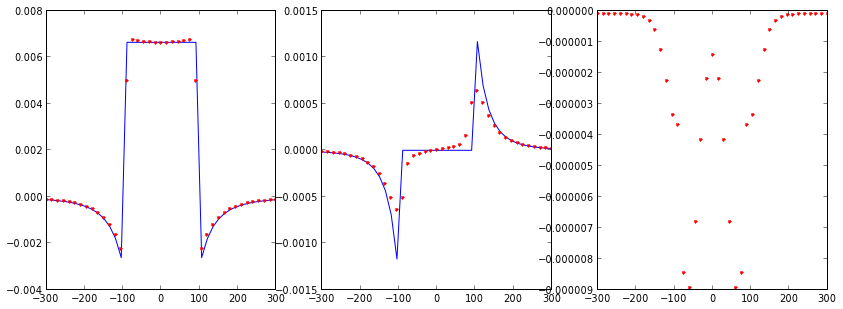

In [25]:
id = 21
fig, axes = subplots(1,3, figsize=(14,5))
epsx = np.linalg.norm(Utils.mkvc(Bxr))*1e-6
epsy = np.linalg.norm(Utils.mkvc(Byr))*1e-6
epsz = np.linalg.norm(Utils.mkvc(Bzr))*1e-6
axes[0].plot(Y[:,id], Bxra[:,id], 'b', Y[:,id], Bxr[:,id], 'r.')
axes[1].plot(Y[:,id], Byra[:,id], 'b', Y[:,id], Byr[:,id], 'r.')
axes[2].plot(Y[:,id], Bzra[:,id], 'b', Y[:,id], Bzr[:,id], 'r.')
print X[:,1]

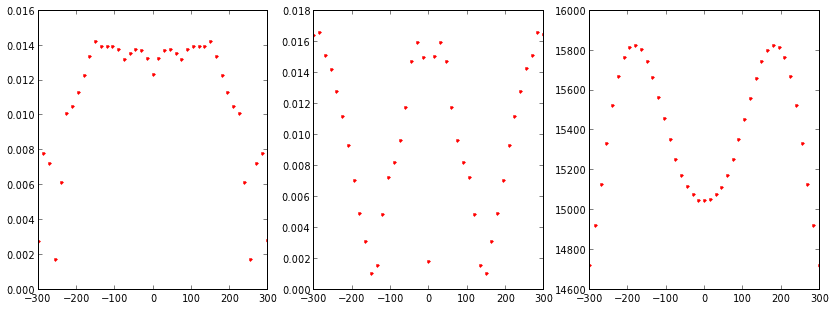

In [26]:
fig, axes = subplots(1,3, figsize=(14,5))
epsx = np.linalg.norm(Utils.mkvc(Bxr))*1e-6
epsy = np.linalg.norm(Utils.mkvc(Byr))*1e-6
epsz = np.linalg.norm(Utils.mkvc(Bzr))*1e-6
axes[0].plot(Y[:,1], abs((Bxr[:,1]-Bxra[:,1])/(Bxra[:,1]+epsx)), 'r.')
axes[1].plot(Y[:,1], abs((Byr[:,1]-Byra[:,1])/(Byra[:,1]+epsy)), 'r.')
axes[2].plot(Y[:,1], abs((Bzr[:,1]-Bzra[:,1])/(Bzra[:,1]+epsz)), 'r.')

### Thoughts

- It works well with non-uniform mesh!!
- Actual accuray is ~10% relative error in secondary fields. As we pad more we can get better accuracy, since we did not consider secondary field at the boudnary ($\partial\Omega$). 
- Here, we can try primary secondary field approach to get better accuracy. 
- In addition, we can use the congruous sphere method to handle this secondary fields at boundaries